# Finding Atomic Orbitals via Minimization

This script uses a **large set of Gaussian-type orbitals (GTOs)** and the **linear variational principle** to approximate the bound states of the hydrogen atom.

The key steps and objectives of the script are:

1. **Build a basis set**:  
A set of 3D Gaussian functions (GTOs) is constructed using a range of exponents (`alphas`) and angular momentum combinations (`nx`, `ny`, `nz`) up to a specified limit (`lmax`). All GTOs are centered at the origin (the hydrogen nucleus).

$$
\phi_{n_x n_y n_z}(\mathbf{r}) = N \cdot (x - X)^{n_x} (y - Y)^{n_y} (z - Z)^{n_z} \cdot e^{-\alpha |\mathbf{r} - \mathbf{R}|^2}
$$

3. **Normalize the basis functions**:  
Each Gaussian is normalized to ensure correct computation of matrix elements.

4. **Construct the overlap matrix $\mathbf{S}$**:  
This matrix contains the inner products between all pairs of basis functions and accounts for their overlap. For the Gaussian-type orbitals used here as a basis, analytical solutions are available and are obtained using the [pyqint](https://ifilot.github.io/pyqint/) library.

5. **Construct the Hamiltonian matrix $\mathbf{H}$**:  
- The kinetic energy of the electron,
- The Coulomb attraction to the nucleus (placed at the origin).

Similar to the construction of the overlap matrix elements, also here analytical solutions are available via the [pyqint](https://ifilot.github.io/pyqint/) library.

7. **Solve the generalized eigenvalue problem $ \mathbf{H} \vec{c} = E \mathbf{S} \vec{c} $**:  
The script transforms the problem into a standard eigenvalue problem using symmetric orthogonalization and solves for the eigenvalues (energies) and eigenvectors (orbital coefficients).

8. **Visualize the energy spectrum**:  
The first 50 eigenvalues (energy levels) are plotted, showing the spectrum of approximate bound states of hydrogen as calculated from the Gaussian basis.

This approach demonstrates how to reproduce atomic orbitals using a purely numerical method, without relying on the analytical hydrogen solutions — just the power of the variational principle and a flexible basis.

**Note that the $n=2$ are 4-fold degenerate. Same goes for the $n=3$ states, they are 9-fold generate**


Cannot find module tqdm
Basis set size: 540


Text(0, 0.5, 'Energy [Ht]')

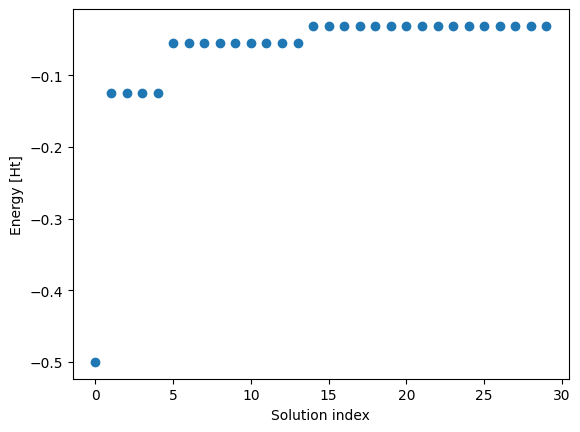

In [1]:
from pyqint import PyQInt, cgf, gto
import numpy as np
import matplotlib.pyplot as plt

# specify basis set parameters
alphas = np.logspace(-2.5,2.5,20)
lmax = 3

# build basis set
gtos = []
for nx in range(0,lmax):
    for ny in range(0,lmax):
        for nz in range(0,lmax):
            for alpha in alphas:
                g = gto(1.0, (0, 0, 0), alpha, nx, ny, nz)
                gtos.append(g)

integrator = PyQInt()

# calculate normalization constants
N = len(gtos)
print('Basis set size: %i' % N)
norms = np.zeros(N)
for i in range(0,N):
    norms[i] = gtos[i].get_norm()

# build overlap matrix
S = np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N):
        S[i,j] = integrator.overlap_gto(gtos[i], gtos[j]) * norms[i] * norms[j]

# build hamiltonian matrix
H = np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N):
        H[i,j] = (integrator.kinetic_gto(gtos[i], gtos[j]) + integrator.nuclear_gto(gtos[i], gtos[j], (0,0,0))) * norms[i] * norms[j]

# construct transformation matrix
e, v = np.linalg.eigh(S)
X = v @ np.diag(1 / np.sqrt(e))  # S^{-1/2}

# solve eigenvalue problem
Hp = X.T @ H @ X
ep, Cp = np.linalg.eigh(Hp)     # Eigenvalues and eigenvectors
C = X @ Cp                      # Transform eigenvectors back

# plot the energies
plt.plot(ep[0:1+4+9+16], 'o')
plt.xlabel('Solution index')
plt.ylabel('Energy [Ht]')

## Visualization of Atomic Orbitals Using Isosurface Rendering

This script generates and visualizes **3D atomic orbitals** by evaluating the wavefunction from a Gaussian basis expansion over a spatial grid.

- Uses the **eigenvectors (orbital coefficients)** obtained from the **variational solution in the previous cell** to reconstruct atomic orbitals.
- Builds a scalar field by evaluating the wavefunction on a 3D grid using these coefficients and the corresponding Gaussian-type orbitals (GTOs).
- Applies the **marching cubes algorithm** to extract **isosurfaces** at positive and negative values of the wavefunction.
- Saves the resulting geometry as `.ply` files.
- Renders interactive **3D visualizations** in the notebook using `pythreejs`, including lighting, color, and wireframe overlays for clarity.

In [2]:
from pytessel import PyTessel
import numpy as np
import trimesh
import pythreejs as p3
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from math import factorial
from scipy.special import assoc_laguerre
from scipy.special import lpmv
from scipy.special import sph_harm

def generate_scalarfield(N, sz, res):
    cvec = C[:,N]
    c = cgf()
    for i in range(len(gtos)):
        c.add_gto(C[i,N], gtos[i].alpha, gtos[i].l, gtos[i].m, gtos[i].n)
        #print(gtos[i])

    x = np.linspace(-sz, sz, res)
    xx, yy, zz = np.meshgrid(x,x,x)
    grid = np.vstack([xx.flatten(), yy.flatten(), zz.flatten()]).reshape(3,-1).T

    field = integrator.plot_wavefunction(grid, [1], [c]).reshape(res, res, res)
    return field

def generate_isosurfaces(N, sz, res, name):
    pytessel = PyTessel()
    field = generate_scalarfield(N, sz, res)
    unitcell = np.diag(np.ones(3) * 3 * 2)
    pytessel = PyTessel()
    isovalue = 0.005
    vertices, normals, indices = pytessel.marching_cubes(field.flatten(), field.shape, unitcell.flatten(), isovalue)
    pytessel.write_ply('%s_pos.ply' % name, vertices, normals, indices)
    vertices, normals, indices = pytessel.marching_cubes(field.flatten(), field.shape, unitcell.flatten(), -isovalue)
    pytessel.write_ply('%s_neg.ply' % name, vertices, normals, indices)

def visualize_mesh(name):
    mesh_pos = trimesh.load_mesh("%s_pos.ply" % name)
    mesh_neg = trimesh.load_mesh("%s_neg.ply" % name)

    geometry_pos = p3.BufferGeometry(
        attributes={
            "position": p3.BufferAttribute(mesh_pos.vertices.astype(np.float32), normalized=False),
            "index": p3.BufferAttribute(mesh_pos.faces.astype(np.uint32).ravel(), normalized=False)
        }
    )
    
    geometry_neg = p3.BufferGeometry(
        attributes={
            "position": p3.BufferAttribute(mesh_neg.vertices.astype(np.float32), normalized=False),
            "index": p3.BufferAttribute(mesh_neg.faces.astype(np.uint32).ravel(), normalized=False),
        }
    )

    solid_material_pos = p3.MeshStandardMaterial(
        color="#276419",
        side="DoubleSide"
    )
    solid_material_neg = p3.MeshStandardMaterial(
        color="#8e0152",
        side="DoubleSide"
    )

    mesh_object_pos = p3.Mesh(geometry=geometry_pos, material=solid_material_pos)
    mesh_object_neg = p3.Mesh(geometry=geometry_neg, material=solid_material_neg)
    mesh_object_pos.rotateY(-np.pi/2)
    mesh_object_neg.rotateY(-np.pi/2)

    # Wireframe Overlay
    wireframe_material = p3.LineBasicMaterial(color="black", linewidth=1.0)  # Thin black lines
    wireframe_pos = p3.LineSegments(
        p3.EdgesGeometry(geometry_pos),  # Extracts edges from geometry
        wireframe_material
    )
    wireframe_neg = p3.LineSegments(
        p3.EdgesGeometry(geometry_neg),  # Extracts edges from geometry
        wireframe_material
    )
    wireframe_pos.rotateY(-np.pi/2)
    wireframe_neg.rotateY(-np.pi/2)

    # Lighting setup
    ambient_light = p3.AmbientLight(color="white", intensity=4)
    
    # Create Scene
    scene = p3.Scene(children=[mesh_object_pos, 
                               mesh_object_neg, 
                               wireframe_pos, 
                               wireframe_neg, 
                               ambient_light, 
                               p3.AxesHelper(size=5)
                              ])
    camera = p3.PerspectiveCamera(position=[5, 5, 5], fov=50)
    controller = p3.OrbitControls(controlling=camera)

    renderer = p3.Renderer(
        scene=scene, camera=camera, controls=[controller], 
        width=512, height=512, antialias=True
    )
    
    return renderer

def parse_orbital(orb):
    match = re.findall(r"-?\d+", orb)  # Extract all numbers
    return tuple(map(int, match))  # Convert to integers and return as tuple

def update_plot(N):
    name = 'AO_%03i' % N
    generate_isosurfaces(N, 25, 71, name)
    renderer = visualize_mesh(name)
    display(renderer)
    
# Create an interactive slider to vary the number of basis functions
N_slider = widgets.IntSlider(
    min=0, max=(1 + 4 + 9 + 16 - 1), step=1, value=0,
    description="Solution index"
)

# Link slider to update function and display interactive UI
widgets.interactive(update_plot, N=N_slider)

interactive(children=(IntSlider(value=0, description='Solution index', max=29), Output()), _dom_classes=('widg…